---
电弧检测（arc-fault detection）
---

## 1. **简介**
**问题陈述**：通过电流、电压的时间序列数据，检测某一时刻是否存在电弧

**方法**：1. 使用机器学习方法进行分类任务；2. 使用变点检测方法侦测时序模式是否发生了改变

**步骤**：1. 数据预处理；2. 特征提取；3. 进行分类/变点检测；4. 方法评估

---
## 2.**数据集**
**github地址**：[IAED](https://github.com/inteverdata/IAED).

**简介**：Intever Public Database for Arcing Event Detection 


**是否公开**：是



**发布时间**：2020

**arc是否有标注**：是0

---
## 3.**代码**

### 3.1 数据预处理

In [1]:
# 导入必要模块
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import copy
from GetData import DataProcess
import statsmodels.api as sm
import time
import os
from PIL import Image
from sklearn.metrics import confusion_matrix
from functions import *

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
# 读取数据集，展示数据框
# k取值范围 1 ~ 25,表示不同的数据集，在这里，区别主要有：用电器、采样频率、连接方式等
k = 9
pl,wsl = Easyget_path_and_windowsize_list()
file_path = pl[k]
window_size = wsl[k]
origin_df = DataProcess(file_path,window_size).merge_all_sample()
sample_rate = origin_df['sample_rate'][0]
origin_df.head(5)

(1910000, 2)
(1910, 2006)


,U_1,U_2,U_3,U_4,U_5,U_6,U_7,U_8,U_9,U_10,...,I_997,I_998,I_999,I_1000,label,sample_rate,sensor,load_config,device_name,connection_method
0,328.480011,330.507996,331.447998,333.723999,334.911011,334.217987,335.208008,336.196991,336.740997,335.899994,...,8.99867,9.13603,9.17829,9.46357,0,10000,recorder,single-load,electricoven,m1
1,328.183990,329.321014,331.546997,334.118988,332.981995,336.295990,335.503998,336.394989,337.483002,336.889008,...,9.13603,9.09376,9.20999,9.13603,0,10000,recorder,single-load,electricoven,m1
2,326.550995,329.963989,331.250000,333.526001,333.723999,335.109009,335.503998,335.355988,336.691010,334.911011,...,9.13603,9.13603,9.09376,9.13603,0,10000,recorder,single-load,electricoven,m1
3,326.006989,329.915009,330.359985,333.130005,333.427002,336.196991,334.761993,335.355988,337.285004,335.454987,...,9.00924,9.11490,9.20999,9.26282,0,10000,recorder,single-load,electricoven,m1
4,326.255005,327.589996,329.569000,332.734009,334.118988,334.217987,335.503998,335.058990,336.295990,335.899994,...,9.09376,8.96697,9.13603,9.34735,0,10000,recorder,single-load,electricoven,m1


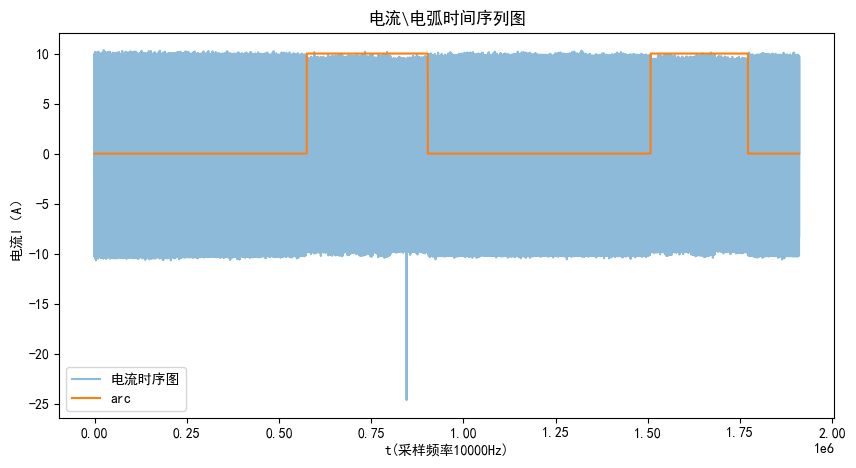

In [3]:
# 原始数据电流时序图
U = origin_df.iloc[:,0:window_size]
I = origin_df.iloc[:,window_size:window_size*2]

arc = origin_df['label'].values

plt.figure(figsize=(10,5))
plt.plot(I.values.ravel(),alpha = 0.5,label = '电流时序图')    # 电流
plt.plot(np.array(sum([[i]*window_size for i in arc],[]))*10,label = 'arc')   # 电弧
plt.xlabel(f't(采样频率{sample_rate}Hz)')
plt.ylabel('电流I（A）')
plt.title('电流\电弧时间序列图')
plt.legend()
plt.show()

---
### 3.2 特征提取

In [4]:
# 从原始数据中提取特征
P = U.values*I.values
feature = np.sum(P<0,axis = 1)   # feature特征

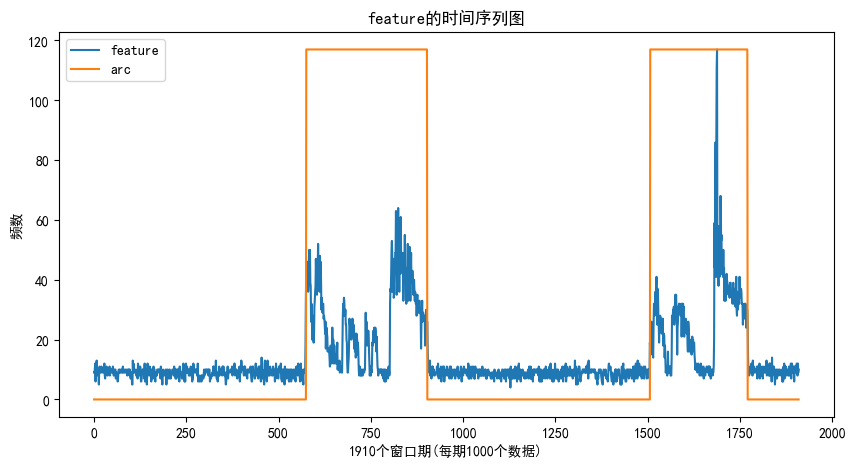

In [5]:
# 当前feature特征是一维的，故能可视化该特征

plt.figure(figsize=(10,5))
plt.xlabel(f'{len(feature)}个窗口期(每期{window_size}个数据)')
plt.ylabel('频数')
plt.title('feature的时间序列图')
plt.plot(feature,label = 'feature')
plt.plot(arc*max(feature),label = 'arc')
plt.legend()
plt.show()

---
### 3.3 进行分类/变点检测任务

#### 3.3.1基于机器学习的方法
---

In [6]:
from ML import ModelTrainer

trainer = ModelTrainer()

X = feature.reshape(-1,1)   # 样本
values = arc   # 类别

split_data_tuple = trainer.split_data(X,values)   # 得到X_train,X_test,y_train,y_test
results = trainer.train_and_evaluate(*split_data_tuple)   # 得到accuracy，FPR,FNR等数据
df_results = pd.DataFrame(results)
df_results

,SVM,Decision Tree,Random Forest,KNN,Logistic Regression,Naive Bayes,Gradient Boosting
FPR,0.007380,0.011070,0.011070,0.011070,0.011070,0.011070,0.011070
FNR,0.207207,0.198198,0.198198,0.198198,0.198198,0.198198,0.198198
Precision,0.977778,0.967391,0.967391,0.967391,0.967391,0.967391,0.967391
Recall,0.792793,0.801802,0.801802,0.801802,0.801802,0.801802,0.801802
Accuracy,0.934555,0.934555,0.934555,0.934555,0.934555,0.934555,0.934555
F1,0.875622,0.876847,0.876847,0.876847,0.876847,0.876847,0.876847
F2,0.823970,0.830224,0.830224,0.830224,0.830224,0.830224,0.830224
F0.5,0.934183,0.929019,0.929019,0.929019,0.929019,0.929019,0.929019


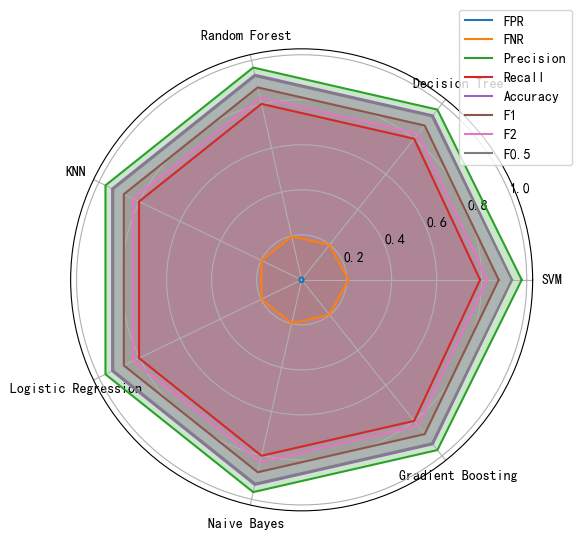

In [7]:
# 不同分类器间的比较可视化
from Visualization import CPLOT
visual = CPLOT(df_results,'Classifier','evaluate')

visual.radar_plot()

#### 3.3.2 基于变点检测的方法

In [8]:
# 这两个参数很重要（运行时长意义上）
is_save = True     # 保存绘制图像(1000张图会耗时数分钟)
is_Merge_to_gif = True  # 可以将绘制的图像合成gif图，更好的可视化变点检测的过程

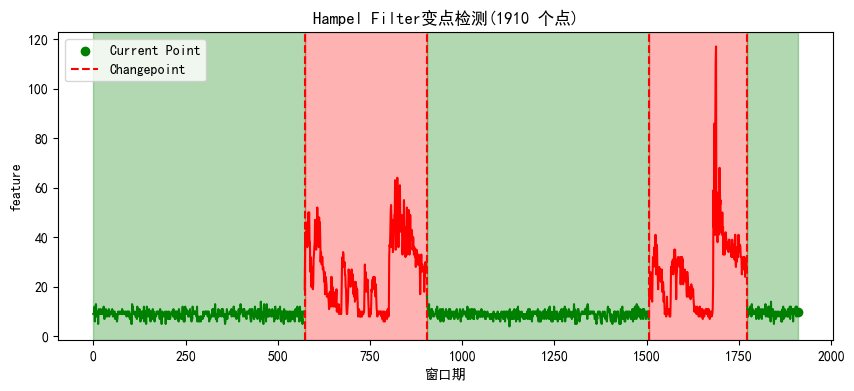

运行时间：547.1925265789032
变点位置为：[(575, 42), (973, 8), (1508, 15), (1841, 11)]
图像会保存在根目录下的"savefigure"文件夹中


In [9]:
from changepoint import CPD

start_time = time.time()
cpd = CPD()
change_points = []

for i, new_point, is_outlier, is_changepoint in cpd.hampel_filter(feature, initial_window_size=40, n_sigmas=3,
                                                                                             is_save = is_save):
    if is_changepoint:
        # 如果当前点是变点，将其添加到变点列表中
        change_points.append((i, new_point))
end_time = time.time()
print(f'运行时间：{end_time - start_time}')
print(f'变点位置为：{change_points}')


# 是否将图片合成gif
if is_Merge_to_gif:
    if is_save:
        cpd.merge_to_gif(duration = 100,loop = 0)
    else:
        pass

if is_save:
    print('图像会保存在根目录下的"savefigure"文件夹中')

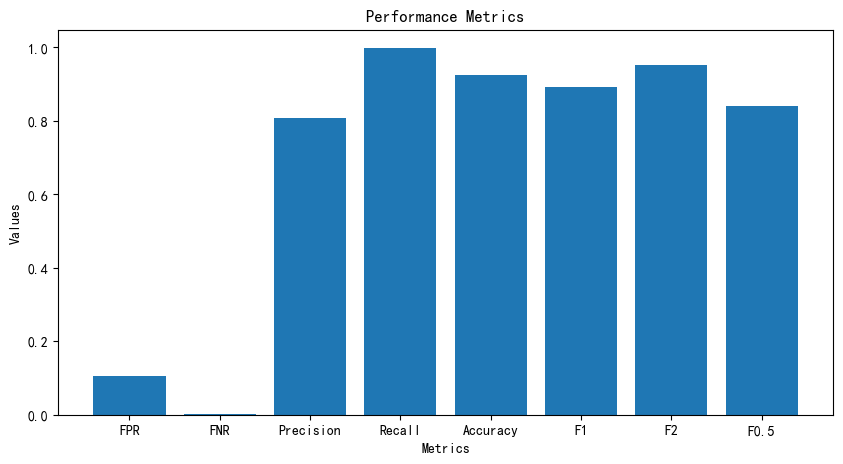

In [10]:
# 计算检测正确率
predicted_arc = cpd.generate_state_sequence(change_points,length = len(feature),initial_state = 0)

metrics = cpd.calculate_performance_metrics(arc, predicted_arc)

# 绘制图表
labels = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize = (10,5))
plt.bar(labels, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')
plt.show()

### 3.4. 方法评估

In [11]:
# 将不同机器学习方法和变点检测方法结果合并 
dfc = copy.deepcopy(df_results)
dfc['CPD'] = metrics
dfc

,SVM,Decision Tree,Random Forest,KNN,Logistic Regression,Naive Bayes,Gradient Boosting,CPD
FPR,0.007380,0.011070,0.011070,0.011070,0.011070,0.011070,0.011070,0.106222
FNR,0.207207,0.198198,0.198198,0.198198,0.198198,0.198198,0.198198,0.001689
Precision,0.977778,0.967391,0.967391,0.967391,0.967391,0.967391,0.967391,0.808482
Recall,0.792793,0.801802,0.801802,0.801802,0.801802,0.801802,0.801802,0.998311
Accuracy,0.934555,0.934555,0.934555,0.934555,0.934555,0.934555,0.934555,0.926178
F1,0.875622,0.876847,0.876847,0.876847,0.876847,0.876847,0.876847,0.893424
F2,0.823970,0.830224,0.830224,0.830224,0.830224,0.830224,0.830224,0.953533
F0.5,0.934183,0.929019,0.929019,0.929019,0.929019,0.929019,0.929019,0.840444


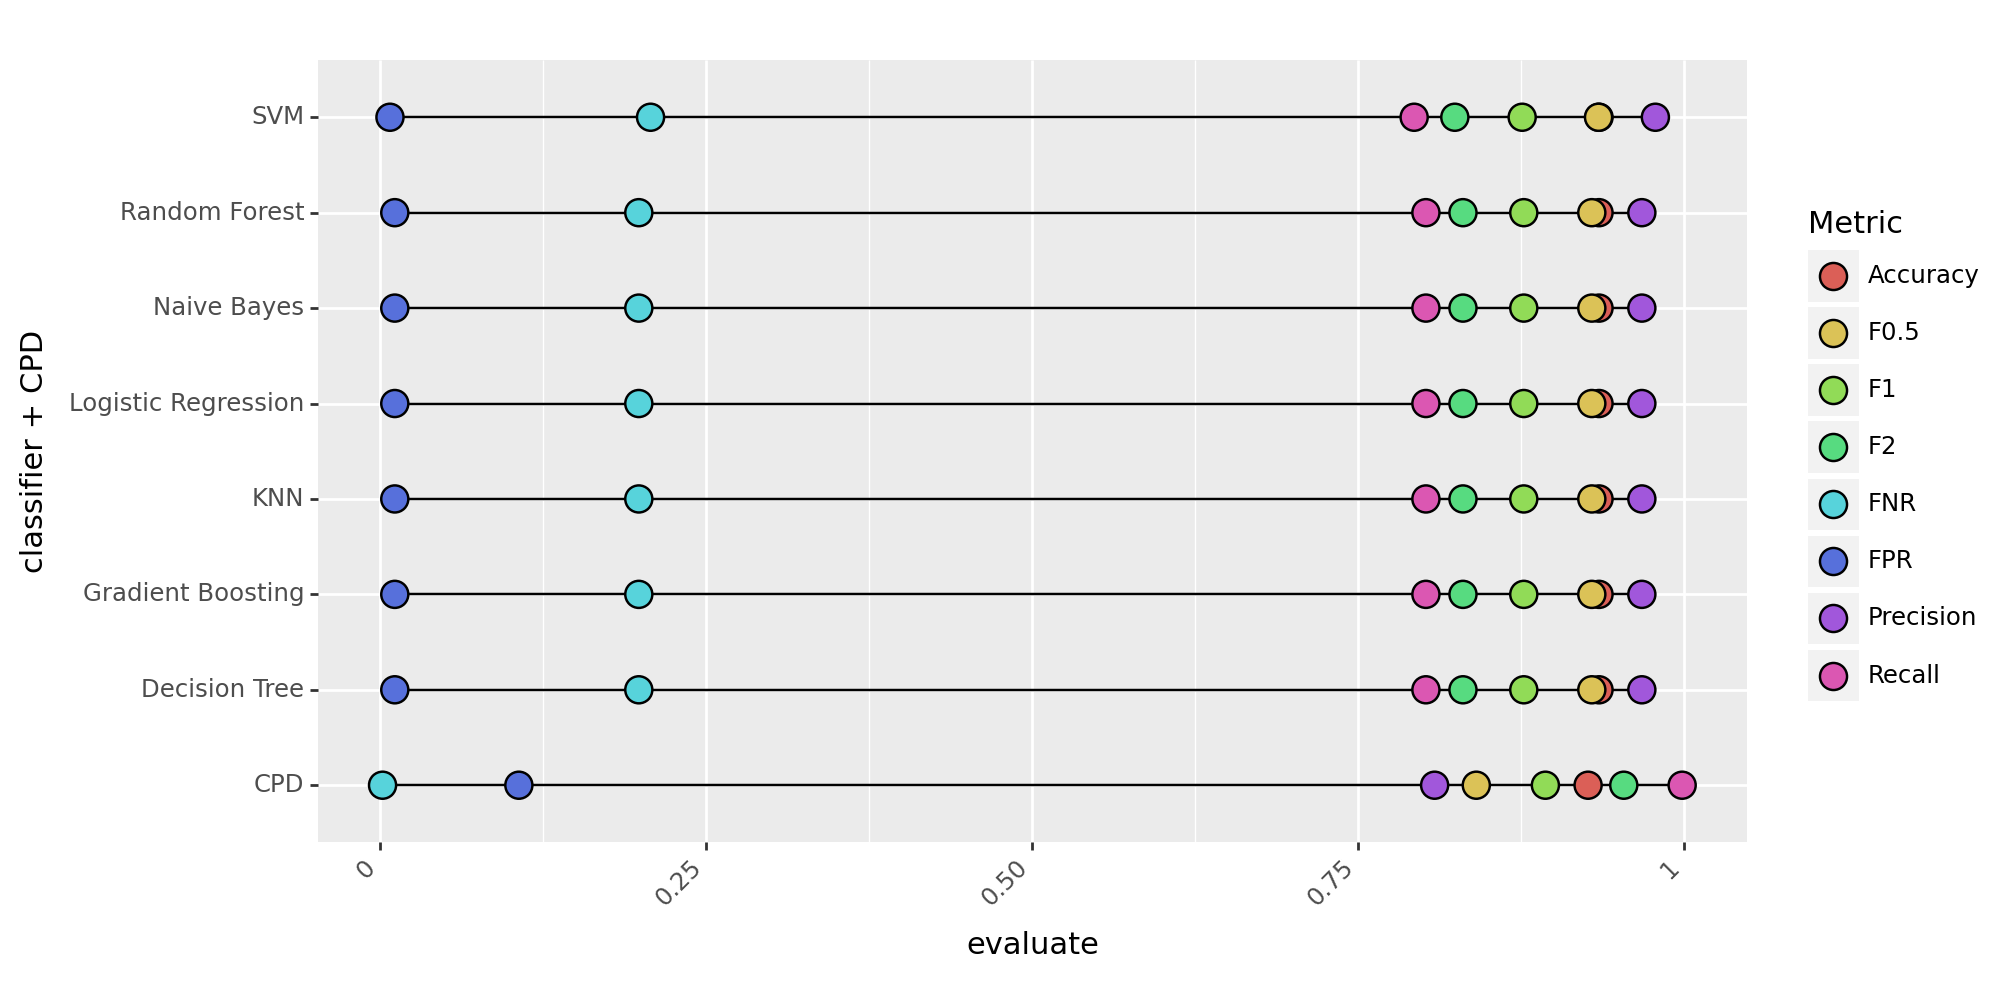

In [12]:
# 可视化结果
visual_merge = CPLOT(dfc,'classifier + CPD','evaluate')
visual_merge.lollipop_plot()   # 棒棒糖图

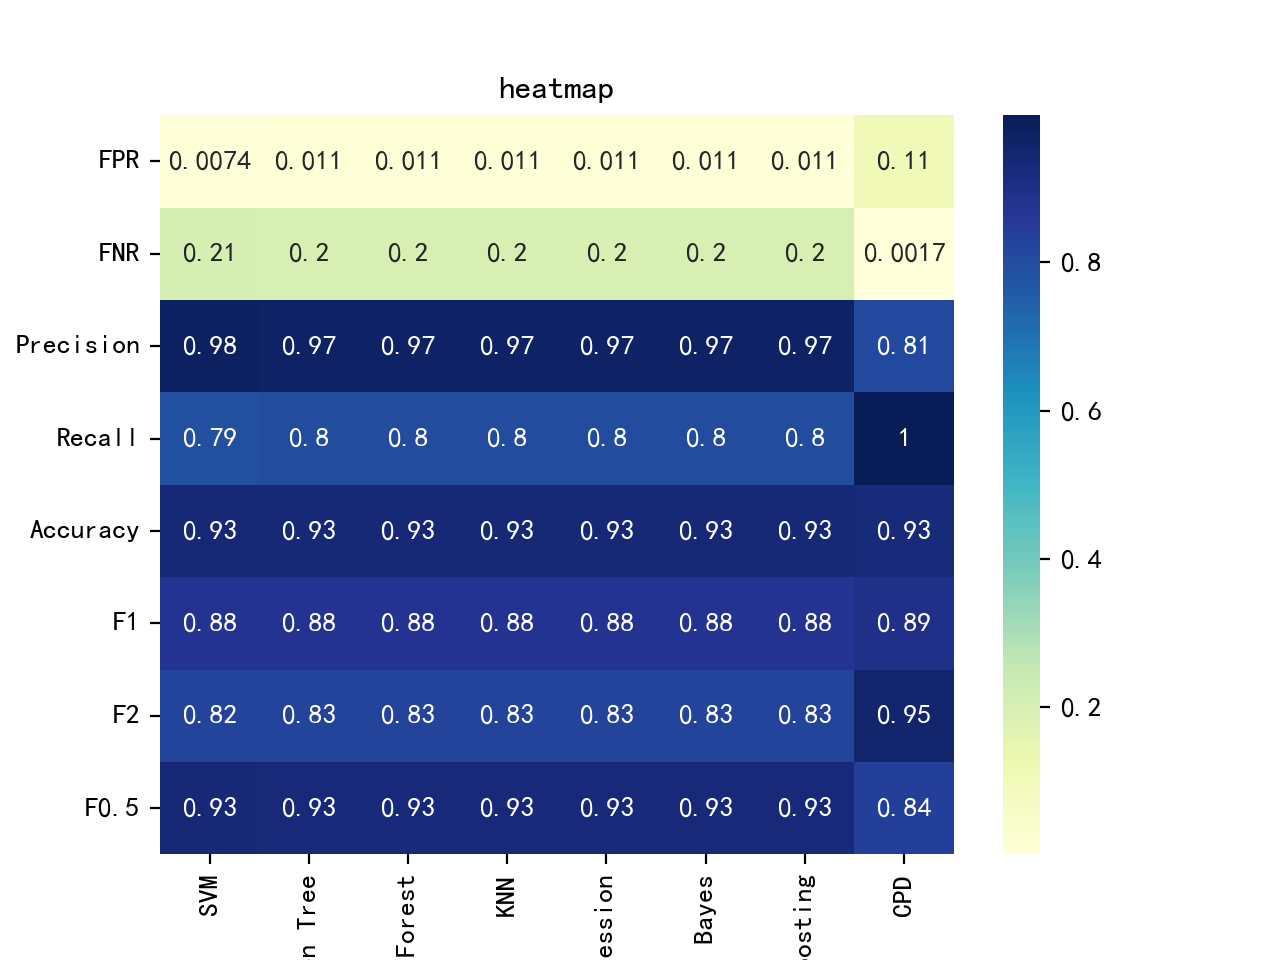

In [13]:
visual_merge.heatmap_plot()  # 热图

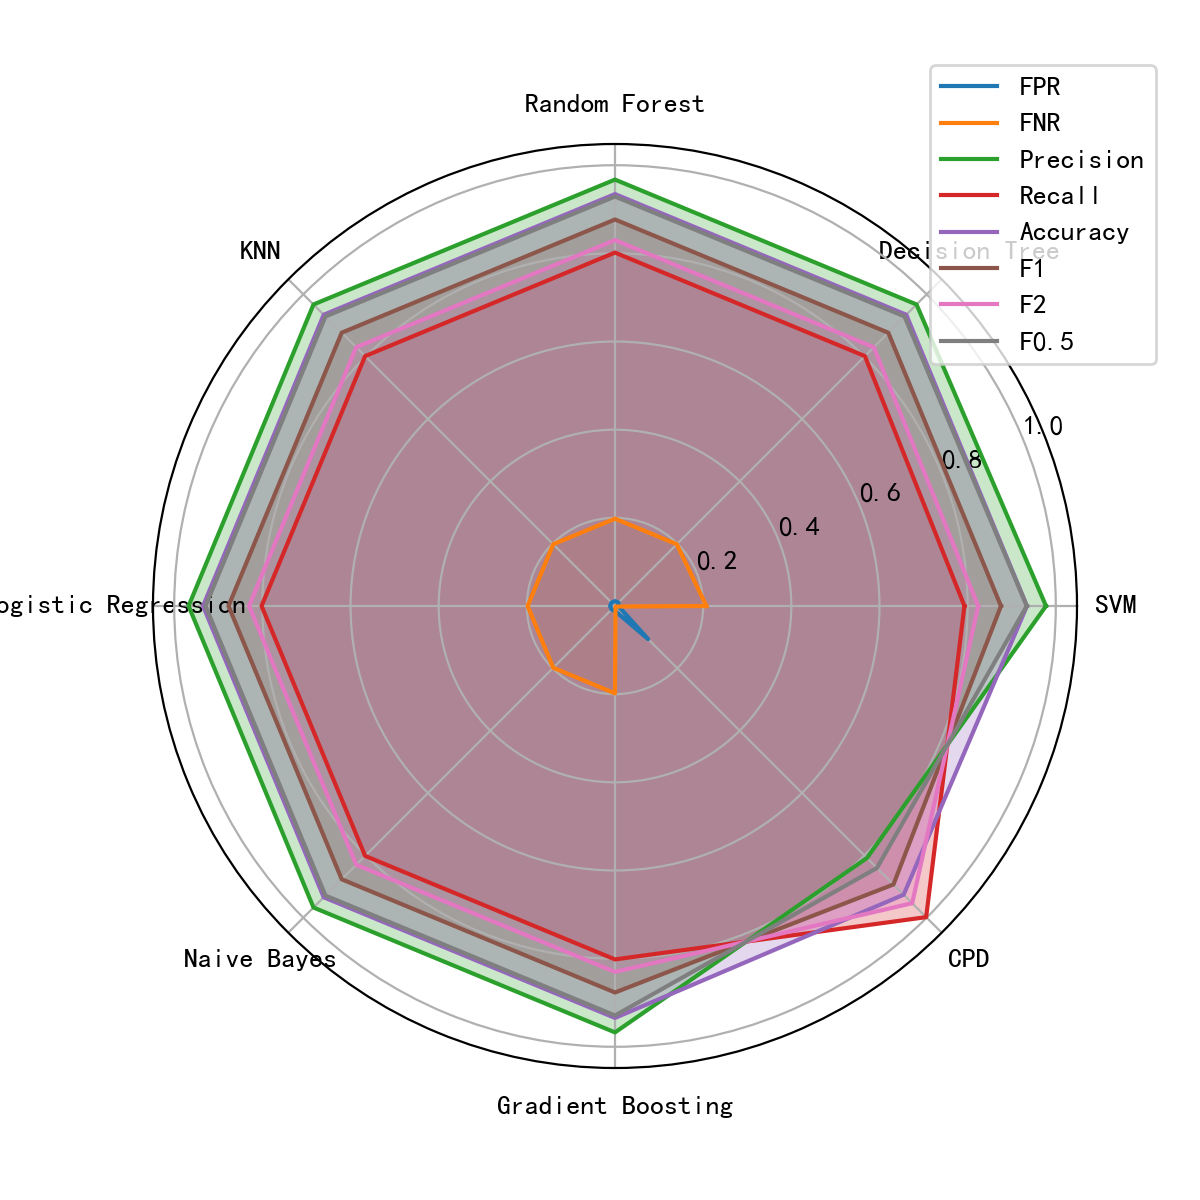

In [14]:
visual_merge.radar_plot()  # 雷达图

## 4. **结论**

ML-机器学习；CPD-变点检测
1. 不同ML方法分类效果十分接近
2. CPD方法和ML方法在查正和查错上各有优势和不足
3. ML准确率(Accuracy)≈93.5%，虚警率(FNR)≈20%
4. CPD准确率(Accuracy)≈92.6%，虚警率(FNR)≈0.1%
5. 考虑到对于电弧检测问题来说，召回率(Recall)更加重要，用F2-score来衡量机器学习方法和变点检测方法效果，有：ML的F2-score≈0.83，CPD的F2-score≈0.95，认为CPD方法更胜一筹

## 5. **可改进的地方**

1. 特征提取上，可以用多种方法提取更高维、更有鲁棒性的特征
2. ML方法可以用更多有标记的数据集来训练，从而能适应更广泛的场景
3. CPD方法可以用其他指标来识别变点，例如均值、方差等，也可以考虑更高维的情形（当前用的是MAD-中位数绝对离差）